# 监督式分类（逻辑斯谛回归）

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm, trange
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from collections import defaultdict
from load_data import load_data,get_SG_FR, similarity_metric, read_Decoding_csv, load_neural_npz
from dataset import LinearRegressionModel, NeuralDataset
from oasis.functions import deconvolve

In [16]:
# 定义目标脑区和会话
target_brain_regions = ['VISp', 'VISal', 'VISl']
session_letters = ['A', 'B']
data_root = '../data'

# 存储所有数据集的分类结果
all_results = {}

# 定义刺激类型映射
stim_type_mapping = {
    'drifting_gratings': 0,
    'static_gratings': 1,
    'natural_scenes': 2,
    'natural_movie': 3  # 包括natural_movie_one和three
}

print("开始处理6个数据集...")
print("="*60)

for region in target_brain_regions:
    for session_letter in session_letters:
        dataset_name = f"{region}_{session_letter}"
        print(f"\n正在处理数据集: {dataset_name}")
        print("-" * 40)
        
        try:
            # 1. 读取元数据
            tgt_dict, tgt_folder = read_Decoding_csv(data_path=data_root, 
                                                    region_type=region, 
                                                    session_letter=session_letter)
            
            # 2. 加载神经活动数据
            neural_file_path = os.path.join(data_root, tgt_folder)
            neural_data_loaded = False
            
            for file_name in os.listdir(neural_file_path):
                if file_name.endswith('.npz'):
                    ts, dff, all_roi_masks, cids, metadata = load_neural_npz(
                        os.path.join(neural_file_path, file_name))
                    neural_data_loaded = True
                    break
            
            if not neural_data_loaded:
                print(f"错误: 未找到 {dataset_name} 的npz文件")
                all_results[dataset_name] = {'status': 'error', 'message': '未找到数据文件'}
                continue
            
            # 3. 提取刺激时间段和创建标签
            stimulus_data = []
            stimulus_labels = []
            stimulus_types = []
            
            # 处理每种刺激类型
            for stim_key, stim_df in tgt_dict.items():
                if 'drifting_gratings' in stim_key:
                    stim_type = 'drifting_gratings'
                elif 'static_gratings' in stim_key:
                    stim_type = 'static_gratings'
                elif 'natural_scenes' in stim_key:
                    stim_type = 'natural_scenes'
                elif 'natural_movie' in stim_key:
                    stim_type = 'natural_movie'
                else:
                    continue  # 跳过其他刺激类型
                
                # 获取刺激开始和结束时间
                for _, row in stim_df.iterrows():
                    start_time = int(row['start'])
                    end_time = int(row['end'])
                    
                    # 检查时间索引有效性
                    if start_time >= 0 and end_time < dff.shape[1] and start_time < end_time:
                        neural_activity = np.mean(dff[:, start_time:end_time], axis=1)
                        stimulus_data.append(neural_activity)
                        stimulus_labels.append(stim_type_mapping[stim_type])
                        stimulus_types.append(stim_type)
            
            # 4. 准备分类数据
            if len(stimulus_data) == 0:
                print(f"错误: {dataset_name} 没有有效的刺激数据")
                all_results[dataset_name] = {'status': 'error', 'message': '没有有效刺激数据'}
                continue
            
            X = np.array(stimulus_data)
            y = np.array(stimulus_labels)
            
            # 检查并处理NaN值
            nan_mask = np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1)
            if nan_mask.any():
                print(f"警告: 发现 {nan_mask.sum()} 个包含NaN/Inf的样本，将被移除")
                X = X[~nan_mask]
                y = y[~nan_mask]
            
            # 检查是否有足够样本和类别
            unique_classes = np.unique(y)
            if len(unique_classes) < 2:
                print(f"警告: {dataset_name} 只有 {len(unique_classes)} 类刺激，无法分类")
                all_results[dataset_name] = {
                    'status': 'insufficient_classes', 
                    'num_classes': len(unique_classes),
                    'classes': unique_classes
                }
                continue
            
            if len(X) < 20:  # 至少需要20个样本
                print(f"警告: {dataset_name} 样本数量不足 ({len(X)} 个)，无法分类")
                all_results[dataset_name] = {
                    'status': 'insufficient_samples', 
                    'num_samples': len(X)
                }
                continue
            
            # 5. 数据预处理
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # 6. 划分训练集和测试集
            try:
                X_train, X_test, y_train, y_test = train_test_split(
                    X_scaled, y, test_size=0.3, random_state=42, stratify=y)
            except ValueError as e:
                print(f"错误: {dataset_name} 数据分割失败: {e}")
                all_results[dataset_name] = {'status': 'split_error', 'message': str(e)}
                continue
            
            # 7. 训练分类器
            classifier = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)
            classifier.fit(X_train, y_train)
            
            # 8. 评估性能
            y_pred = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            # 9. 保存详细结果
            class_names = [k for k, v in stim_type_mapping.items() if v in unique_classes]
            
            all_results[dataset_name] = {
                'status': 'success',
                'accuracy': accuracy,
                'num_samples': len(y),
                'num_neurons': X.shape[1],
                'classes': unique_classes,
                'class_names': class_names,
                'classification_report': classification_report(y_test, y_pred, target_names=class_names, output_dict=True),
                'brain_region': region,
                'session': session_letter
            }
            
            print(f"✓ {dataset_name} 处理成功")
            print(f"  准确率: {accuracy:.4f}")
            print(f"  样本数: {len(y)}, 神经元数: {X.shape[1]}")
            print(f"  刺激类型: {class_names}")
            
        except Exception as e:
            print(f"错误: {dataset_name} 处理失败: {e}")
            all_results[dataset_name] = {'status': 'error', 'message': str(e)}

print("\n" + "="*60)
print("所有数据集处理完成！")

开始处理6个数据集...

正在处理数据集: VISp_A
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISp_A 处理成功
  准确率: 0.9748
  样本数: 23181, 神经元数: 142
  刺激类型: ['drifting_gratings', 'natural_movie']

正在处理数据集: VISp_B
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISp_B 处理成功
  准确率: 0.8443
  样本数: 16501, 神经元数: 174
  刺激类型: ['static_gratings', 'natural_scenes', 'natural_movie']

正在处理数据集: VISal_A
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISal_A 处理成功
  准确率: 0.9803
  样本数: 23217, 神经元数: 181
  刺激类型: ['drifting_gratings', 'natural_movie']

正在处理数据集: VISal_B
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISal_B 处理成功
  准确率: 0.7327
  样本数: 16447, 神经元数: 172
  刺激类型: ['static_gratings', 'natural_scenes', 'natural_movie']

正在处理数据集: VISl_A
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISl_A 处理成功
  准确率: 0.9849
  样本数: 23115, 神经元数: 153
  刺激类型: ['drifting_gratings', 'natural_movie']

正在处理数据集: VISl_B
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ VISl_B 处理成功
  准确率: 0.7210
  样本数: 34998, 神经元数: 175
  刺激类型: ['drifting_gratings', 'static_gratings', 'natural_scenes', 'natural_movie']

所有数据集处理完成！


/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/friiz/anaconda3/envs/pbl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}


======= 6个数据集分类结果综合比较 =======

成功处理的数据集:
Dataset Brain_Region Session  Accuracy  Num_Samples  Num_Neurons  Num_Classes                                                       Class_Names
 VISp_A         VISp       A  0.974838        23181          142            2                                  drifting_gratings, natural_movie
 VISp_B         VISp       B  0.844274        16501          174            3                    static_gratings, natural_scenes, natural_movie
VISal_A        VISal       A  0.980333        23217          181            2                                  drifting_gratings, natural_movie
VISal_B        VISal       B  0.732725        16447          172            3                    static_gratings, natural_scenes, natural_movie
 VISl_A         VISl       A  0.984859        23115          153            2                                  drifting_gratings, natural_movie
 VISl_B         VISl       B  0.721048        34998          175            4 drifting_grating

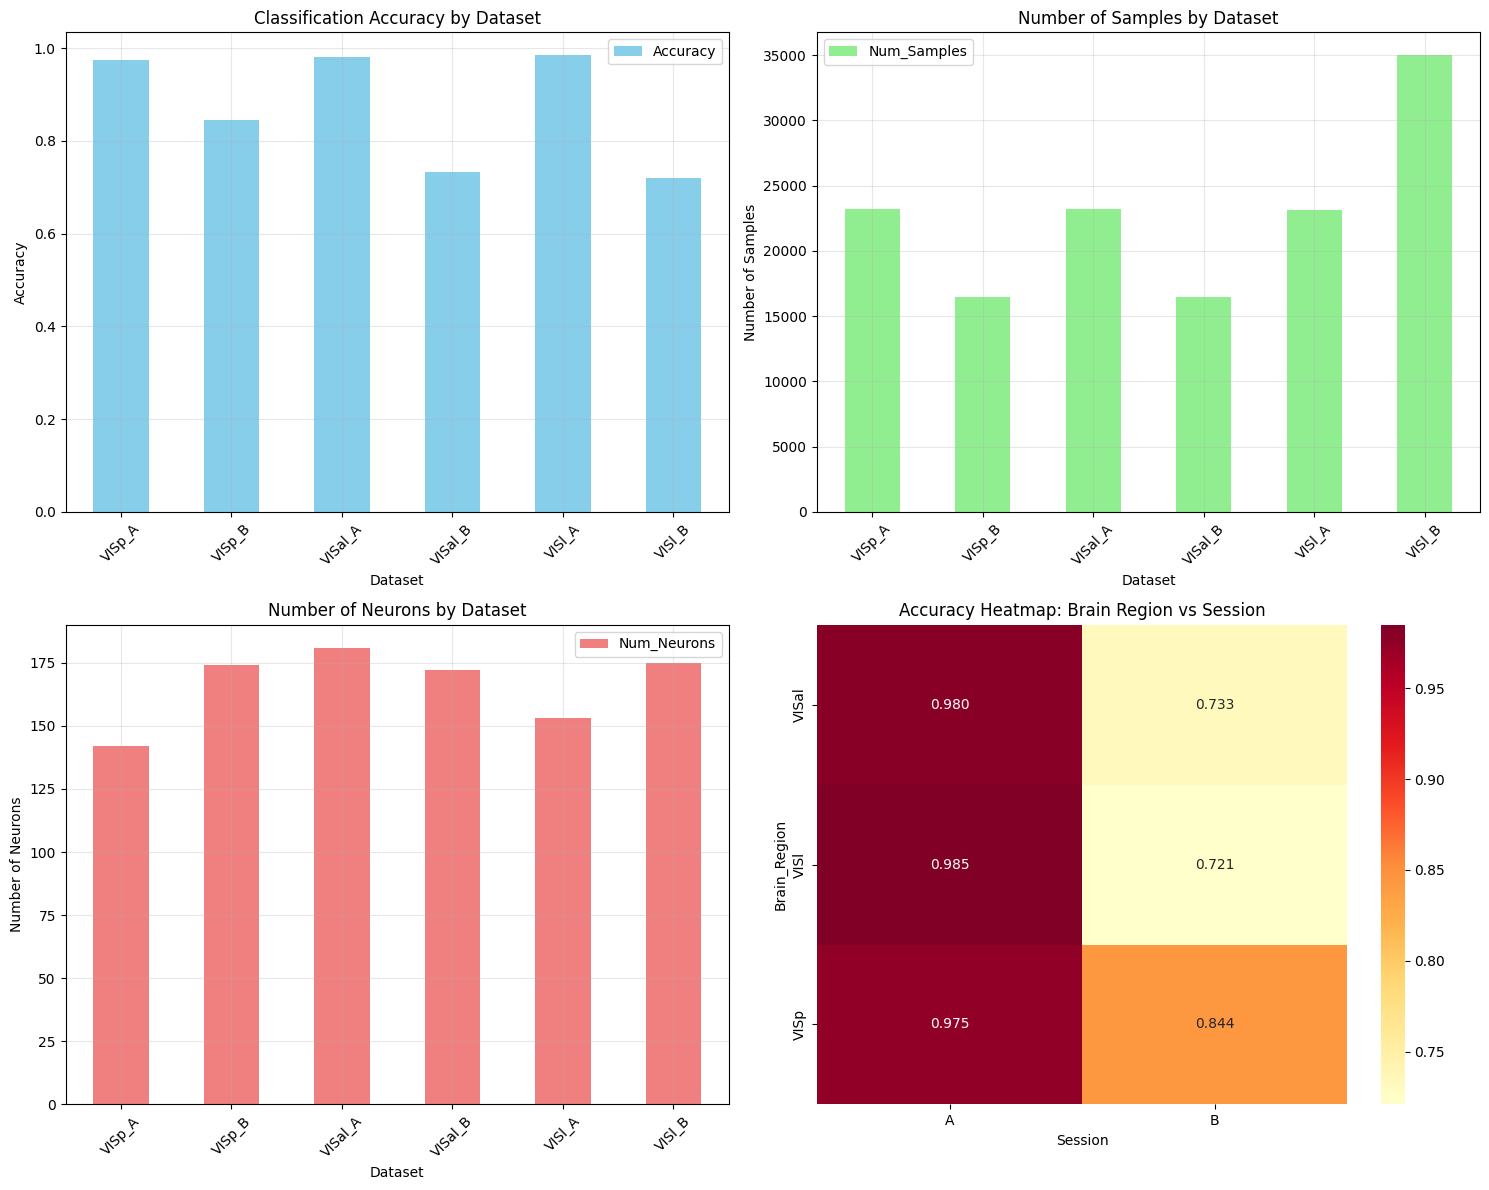


======= 统计分析 =======

按脑区分组的平均准确率:
                  mean       std  count
Brain_Region                           
VISal         0.856529  0.175085      2
VISl          0.852954  0.186543      2
VISp          0.909556  0.092323      2

按会话分组的平均准确率:
             mean       std  count
Session                           
A        0.980010  0.005018      3
B        0.766016  0.068025      3

总体统计:
平均准确率: 0.8730 ± 0.1249
最高准确率: 0.9849 (VISl_A)
最低准确率: 0.7210 (VISl_B)

处理完成！


In [17]:
# 10. 生成综合比较报告
print("\n======= 6个数据集分类结果综合比较 =======")

# 创建结果汇总表
summary_data = []
successful_results = {}

for dataset_name, result in all_results.items():
    if result['status'] == 'success':
        successful_results[dataset_name] = result
        summary_data.append({
            'Dataset': dataset_name,
            'Brain_Region': result['brain_region'],
            'Session': result['session'],
            'Accuracy': result['accuracy'],
            'Num_Samples': result['num_samples'],
            'Num_Neurons': result['num_neurons'],
            'Num_Classes': len(result['classes']),
            'Class_Names': ', '.join(result['class_names'])
        })
    else:
        print(f"❌ {dataset_name}: {result['status']} - {result.get('message', '')}")

# 创建DataFrame用于比较
if summary_data:
    df_summary = pd.DataFrame(summary_data)
    print("\n成功处理的数据集:")
    print(df_summary.to_string(index=False))
    
    # 11. 可视化比较
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 11.1 准确率比较
    ax1 = axes[0, 0]
    df_summary.plot(x='Dataset', y='Accuracy', kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Classification Accuracy by Dataset')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 11.2 样本数比较
    ax2 = axes[0, 1]
    df_summary.plot(x='Dataset', y='Num_Samples', kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Number of Samples by Dataset')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 11.3 神经元数比较
    ax3 = axes[1, 0]
    df_summary.plot(x='Dataset', y='Num_Neurons', kind='bar', ax=ax3, color='lightcoral')
    ax3.set_title('Number of Neurons by Dataset')
    ax3.set_ylabel('Number of Neurons')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 11.4 脑区和会话的准确率热图
    ax4 = axes[1, 1]
    pivot_data = df_summary.pivot(index='Brain_Region', columns='Session', values='Accuracy')
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
    ax4.set_title('Accuracy Heatmap: Brain Region vs Session')
    
    plt.tight_layout()
    plt.show()
    
    # 12. 统计分析
    print("\n======= 统计分析 =======")
    
    # 按脑区分组比较
    print("\n按脑区分组的平均准确率:")
    region_accuracy = df_summary.groupby('Brain_Region')['Accuracy'].agg(['mean', 'std', 'count'])
    print(region_accuracy)
    
    # 按会话分组比较
    print("\n按会话分组的平均准确率:")
    session_accuracy = df_summary.groupby('Session')['Accuracy'].agg(['mean', 'std', 'count'])
    print(session_accuracy)
    
    # 总体统计
    print(f"\n总体统计:")
    print(f"平均准确率: {df_summary['Accuracy'].mean():.4f} ± {df_summary['Accuracy'].std():.4f}")
    print(f"最高准确率: {df_summary['Accuracy'].max():.4f} ({df_summary.loc[df_summary['Accuracy'].idxmax(), 'Dataset']})")
    print(f"最低准确率: {df_summary['Accuracy'].min():.4f} ({df_summary.loc[df_summary['Accuracy'].idxmin(), 'Dataset']})")

else:
    print("❌ 没有成功处理的数据集")

print("\n处理完成！")